## Imports

In [1]:
import warnings
# warnings.filterwarnings("ignore")
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, UpSampling2D, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image 
from collections import Counter
import random

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import clear_output


## Constants

In [2]:
url = "https://sid.erda.dk/public/archives/ff17dc924eba88d5d01a807357d6614c/FullIJCNN2013.zip"
filename = "FullIJCNN2013.zip"

data_dir = '/kaggle/working/FullIJCNN2013/FullIJCNN2013'
gt_file = '/kaggle/working/FullIJCNN2013/FullIJCNN2013/gt.txt'

annotations_file = "/kaggle/working/FullIJCNN2013/FullIJCNN2013/gt.txt"
images_dir       = "/kaggle/working/FullIJCNN2013/FullIJCNN2013"

class_number = 5
num_classes = 5 #4  

class_mapping = {
    0: "speed limit 20 (prohibitory)",
    1: "speed limit 30 (prohibitory)",
    2: "speed limit 50 (prohibitory)",
    3: "speed limit 60 (prohibitory)",
    4: "speed limit 70 (prohibitory)",
    5: "speed limit 80 (prohibitory)",
    6: "restriction ends 80 (other)",
    7: "speed limit 100 (prohibitory)",
    8: "speed limit 120 (prohibitory)",
    9: "no overtaking (prohibitory)",
    10: "no overtaking (trucks) (prohibitory)",
    11: "priority at next intersection (danger)",
    12: "priority road (other)",
    13: "give way (other)",
    14: "stop (other)",
    15: "no traffic both ways (prohibitory)",
    16: "no trucks (prohibitory)",
    17: "no entry (other)",
    18: "danger (danger)",
    19: "bend left (danger)",
    20: "bend right (danger)",
    21: "bend (danger)",
    22: "uneven road (danger)",
    23: "slippery road (danger)",
    24: "road narrows (danger)",
    25: "construction (danger)",
    26: "traffic signal (danger)",
    27: "pedestrian crossing (danger)",
    28: "school crossing (danger)",
    29: "cycles crossing (danger)",
    30: "snow (danger)",
    31: "animals (danger)",
    32: "restriction ends (other)",
    33: "go right (mandatory)",
    34: "go left (mandatory)",
    35: "go straight (mandatory)",
    36: "go right or straight (mandatory)",
    37: "go left or straight (mandatory)",
    38: "keep right (mandatory)",
    39: "keep left (mandatory)",
    40: "roundabout (mandatory)",
    41: "restriction ends (overtaking) (other)",
    42: "restriction ends (overtaking (trucks)) (other)"
}

## Utility functions

In [3]:
def get_class_value(class_number):
    return class_mapping.get(class_number, "Unknown class number")

def plot_annotations(image_path, annotations, image_number):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')

    plt.title(f"Image: {image_number}")

    for annotation in annotations:
        left, top, right, bottom, class_id = annotation
        class_name = class_mapping.get(class_id, "Unknown class")
        rect = plt.Rectangle((left, top), right-left, bottom-top, edgecolor='red', facecolor='none', linewidth=1)
        plt.gca().add_patch(rect)
        plt.text(left, top-20, class_name, color='red', fontsize=8, backgroundcolor='white', bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

    plt.show()

def load_annotations(gt_file):
    annotations = {}
    with open(gt_file, 'r') as file:
        lines = file.readlines()
        for line in lines:
            parts = line.strip().split(';')
            img_file = parts[0]
            left, top, right, bottom, class_id = map(int, parts[1:])
            if img_file not in annotations:
                annotations[img_file] = []
            annotations[img_file].append((left, top, right, bottom, class_id))
    return annotations

def plot_samples(data_dir, gt_file, sample_count):
    annotations = load_annotations(gt_file)
    img_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.ppm')])

    random.shuffle(img_files)
    selected_files = img_files[:sample_count]

    for img_file in selected_files:
        img_path = os.path.join(data_dir, img_file)
        image_number = img_file.split('.')[0]
        if img_file in annotations:
            plot_annotations(img_path, annotations[img_file], image_number)

def categorize_objects(annotations):
    object_sizes = {'small': 0, 'medium': 0, 'large': 0}
    for img_file, objs in annotations.items():
        for obj in objs:
            left, top, right, bottom, class_id = obj
            width = right - left
            if width < 32:
                object_sizes['small'] += 1
            elif 32 <= width and width < 45:
                object_sizes['medium'] += 1
            else:
                object_sizes['large'] += 1
    return object_sizes

def plot_histogram(object_sizes):
    categories = list(object_sizes.keys())
    counts = list(object_sizes.values())

    plt.bar(categories, counts, color=['blue', 'orange', 'green'])
    plt.xlabel('Object Size')
    plt.ylabel('Count')
    plt.title('Object Size Distribution')
    plt.show()

def count_objects_by_class(annotations):
    class_counts = Counter()
    for img_file, objs in annotations.items():
        for obj in objs:
            class_id = obj[4]
            class_name = class_mapping.get(class_id, "Unknown class")
            class_counts[class_name] += 1
    return class_counts

def plot_class_histogram(data, title, xlabel, ylabel, color='purple'):
    categories = list(data.keys())
    counts = list(data.values())

    plt.figure(figsize=(12, 8))  # Increase figure size for better spacing
    plt.barh(categories, counts, color=color, height=0.8)  # Increase the height of bars for more spacing
    plt.xlabel(ylabel)  # Switch xlabel and ylabel for horizontal bar chart
    plt.ylabel(xlabel)
    plt.title(title)
    plt.gca().invert_yaxis()  # Invert y-axis to plot right to left
    plt.show()

## Implementation

In [4]:
try:
    os.system(f"wget -O {filename} {url}")
    clear_output(wait=True)
    print(f"{filename} downloaded successfully.")
except Exception as e:
    print("An error occurred while downloading the dataset:", str(e))

FullIJCNN2013.zip downloaded successfully.


In [5]:
if os.path.exists(filename):
    try:
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall("FullIJCNN2013")  
        print(f"{filename} extracted successfully.")
    except Exception as e:
        print("An error occurred while extracting the dataset:", str(e))
else:
    print(f"{filename} not found for extraction.")

FullIJCNN2013.zip extracted successfully.


In [6]:
# print(f"Class {class_number}: {get_class_value(class_number)}")

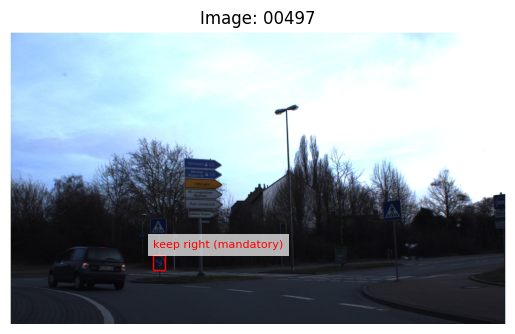

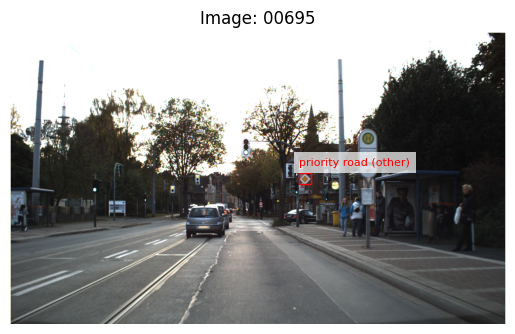

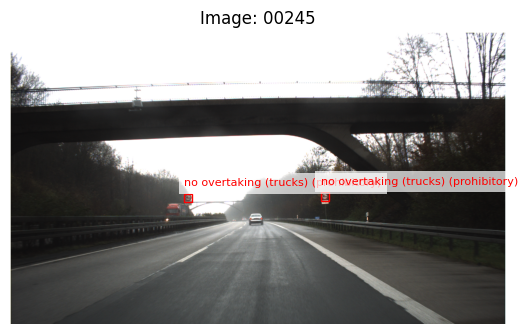

In [7]:
plot_samples(data_dir, gt_file, sample_count=3)

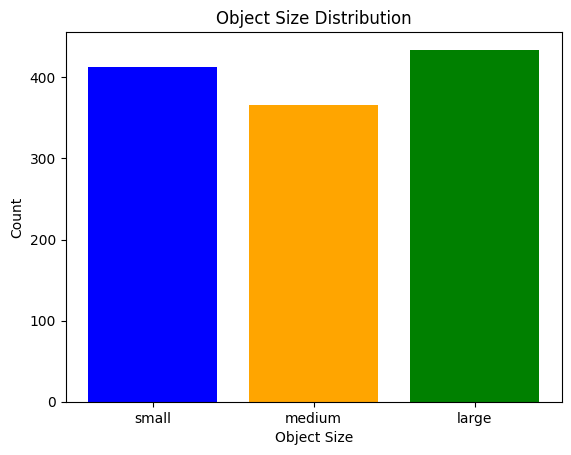

In [8]:
annotations = load_annotations(gt_file)
object_sizes = categorize_objects(annotations)
plot_histogram(object_sizes)

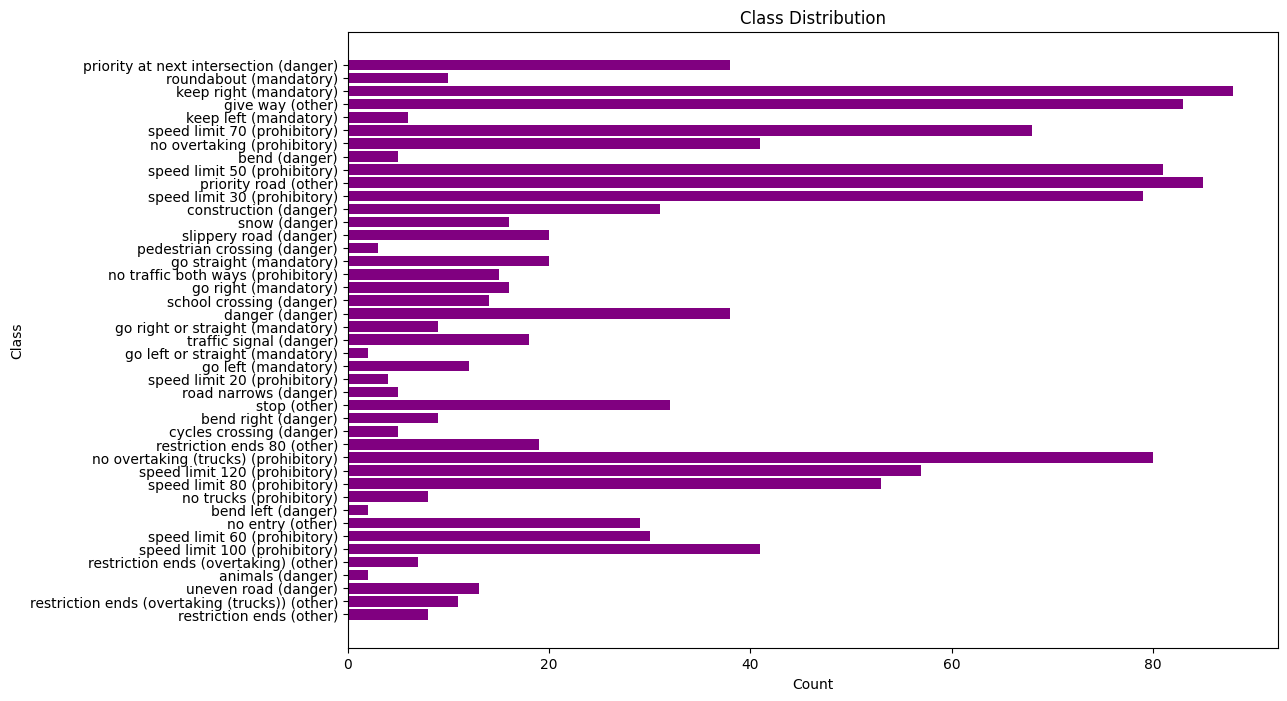

In [9]:
class_counts = count_objects_by_class(annotations)
plot_class_histogram(class_counts, "Class Distribution", "Class", "Count", color='purple')


In [10]:
from torch.utils.data import Dataset, Subset

class FullIJCNN2013Dataset(Dataset):
    def __init__(self, annotations_file, images_dir, transform=None):
        self.annotations = self._load_annotations(annotations_file)
        self.images_dir = images_dir
        self.transform = transform
        self.label_to_id = {
            "prohibitory": 1,
            "danger": 2,
            "mandatory": 3,
            "other": 4
        }

    def _load_annotations(self, annotations_file):
        category_mapping = {
            "prohibitory": list(range(0, 6)) + list(range(7, 11)) + [15, 16],
            "danger": list(range(18, 32)) + [11],
            "mandatory": list(range(33, 41)),
            "other": [6, 12, 13, 14, 17, 32, 41, 42]
        }

        category_lookup = {}
        for category, ids in category_mapping.items():
            for cid in ids:
                category_lookup[cid] = category

        annotations = {}
        with open(annotations_file, "r") as file:
            for line in file:
                parts = line.strip().split(";")
                img_name = parts[0]
                bbox = tuple(map(int, parts[1:5]))
                class_id = int(parts[5])
                category = category_lookup.get(class_id, "other")

                if img_name not in annotations:
                    annotations[img_name] = []
                annotations[img_name].append({"bbox": bbox, "label": category})
        return annotations

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = list(self.annotations.keys())[idx]
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        objects = self.annotations[img_name]
        bboxes = torch.tensor([obj["bbox"] for obj in objects], dtype=torch.float32)
        labels = torch.tensor(
            [self.label_to_id[obj["label"]] for obj in objects], dtype=torch.int64
        )

        target = {
            "boxes": bboxes,
            "labels": labels
        }

        if self.transform:
            image = self.transform(image)

        return image, target

    def split_dataset(self, train_ratio=0.7, val_ratio=0.2, random_state=42):
        indices = list(range(len(self)))
        train_size = train_ratio
        val_test_size = 1 - train_ratio
        val_size = val_ratio / val_test_size

        train_indices, temp_indices = train_test_split(indices, test_size=val_test_size, random_state=random_state)
        val_indices, test_indices = train_test_split(temp_indices, test_size=1 - val_size, random_state=random_state)

        train_dataset = Subset(self, train_indices)
        val_dataset = Subset(self, val_indices)
        test_dataset = Subset(self, test_indices)

        return train_dataset, val_dataset, test_dataset


In [11]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torch.utils.data import DataLoader
from torchvision.transforms import functional as F

In [12]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [13]:
def get_dataloaders(dataset, batch_size=4):
    train_dataset, val_dataset, _ = dataset.split_dataset()
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn
    )
    return train_loader, val_loader

In [14]:
# from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# def get_model(num_classes):
#     model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="COCO_V1")

#     in_features = model.roi_heads.box_predictor.cls_score.in_features
#     model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

#     return model
def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    # Update the classifier to match the number of classes
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
        in_features, num_classes
    )
    return model

In [60]:
def print_training_update(device, epoch, batch_idx, total_batches, loss): 
    print(f"Device: {device}, Epoch: {epoch}, Batch: {batch_idx}/{total_batches}, Loss: {loss:.4f}")

def train_one_epoch(model, optimizer, train_loader, device, epoch):
    model.train()
    for i, (images, targets) in enumerate(train_loader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        losses.backward()
        #xm.optimizer_step(optimizer)

        if i % 10 == 0:
            print_training_update(device, epoch, i, len(train_loader), losses.item())

def evaluate(model, val_loader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, targets in val_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            print(type(loss_dict))
            print()
            print(loss_dict)
            # losses = sum(loss_dict)
            losses = sum(loss_dict.values())
            total_loss += losses.item()
    return total_loss / len(val_loader)

In [61]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [62]:
dataset = FullIJCNN2013Dataset(annotations_file, images_dir, transform=F.to_tensor)
train_loader, val_loader = get_dataloaders(dataset)

model = get_model(num_classes).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

num_epochs = 1 #10
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_one_epoch(model, optimizer, train_loader, device, epoch)
    val_loss = evaluate(model, val_loader, device)
    print(f"Validation Loss: {val_loss:.4f}")

xm.save(model.state_dict(), "fasterrcnn_resnet50_tpu.pth")

Epoch 1/1
Device: cuda, Epoch: 0, Batch: 0/130, Loss: 1.9667
Device: cuda, Epoch: 0, Batch: 10/130, Loss: 1.9738
Device: cuda, Epoch: 0, Batch: 20/130, Loss: 1.9237
Device: cuda, Epoch: 0, Batch: 30/130, Loss: 1.9899
Device: cuda, Epoch: 0, Batch: 40/130, Loss: 2.0179
Device: cuda, Epoch: 0, Batch: 50/130, Loss: 1.9505
Device: cuda, Epoch: 0, Batch: 60/130, Loss: 1.9891
Device: cuda, Epoch: 0, Batch: 70/130, Loss: 2.0430
Device: cuda, Epoch: 0, Batch: 80/130, Loss: 1.8961
Device: cuda, Epoch: 0, Batch: 90/130, Loss: 1.9696
Device: cuda, Epoch: 0, Batch: 100/130, Loss: 2.0174
Device: cuda, Epoch: 0, Batch: 110/130, Loss: 1.9660
Device: cuda, Epoch: 0, Batch: 120/130, Loss: 1.9357
<class 'list'>

[{'boxes': tensor([[ 127.0188,  356.4995,  313.8744,  577.1392],
        [  77.3968,  687.8387,  320.7843,  785.2911],
        [ 310.7523,  431.3695,  407.0587,  503.8209],
        [ 656.0598,  396.4907, 1282.7035,  613.4039],
        [  57.6653,  457.1522,  422.7136,  591.1347],
        [1202.2

AttributeError: 'list' object has no attribute 'values'